In [ ]:
# %%bash
# # Download the TensorFlow Serving Docker image and repo
# docker pull tensorflow/serving

# git clone https://github.com/tensorflow/serving
# # Location of demo models
# TESTDATA="$(pwd)/serving/tensorflow_serving/servables/tensorflow/testdata"

# # Start TensorFlow Serving container and open the REST API port
# docker run -t --rm -p 8501:8501 \
#     -v "$TESTDATA/saved_model_half_plus_two_cpu:/models/half_plus_two" \
#     -e MODEL_NAME=half_plus_two \
#     tensorflow/serving &

# curl -d '{"instances": [1.0, 2.0, 5.0]}' \
#     -X POST http://localhost:8501/v1/models/half_plus_two:predict


The serving images (both CPU and GPU) have the following properties:
- Port 8500 exposed for gRPC
- Port 8501 exposed for the REST API
- Optional environment variable MODEL_NAME (defaults to model)
- Optional environment variable MODEL_BASE_PATH (defaults to /models)

When the serving image runs ModelServer, it runs it as follows:

`tensorflow_model_server --port=8500 --rest_api_port=8501 \
  --model_name=${MODEL_NAME} --model_base_path=${MODEL_BASE_PATH}/${MODEL_NAME}`

To serve with Docker, you'll need:
- An open port on your host to serve on
- A SavedModel to serve
- A name for your model that your client will refer to

`docker run -p 8501:8501 \
  --mount type=bind,source=/path/to/my_model/,target=/models/my_model \
  -e MODEL_NAME=my_model -t tensorflow/serving
`

In this case, we've started a Docker container, published the REST API port 8501 to our host's port 8501, and taken a model we named `my_model` and bound it to the default model base path (`${MODEL_BASE_PATH}/${MODEL_NAME} = /models/my_model`). Finally, we've filled in the environment variable `MODEL_NAME` with `my_model`, and left `MODEL_BASE_PATH` to its default value.

In [6]:
import os
import tensorflow as tf

MODEL_BASE_PATH = "models"
MODEL_NAME = "20231120-094457"
tf.saved_model.contains_saved_model(
    os.path.join(MODEL_BASE_PATH, MODEL_NAME)
)

True

In [7]:
model = tf.saved_model.load(os.path.join(MODEL_BASE_PATH, MODEL_NAME))

In [ ]:
%%bash
MODEL_NAME="20231120-094457"
MODEL_BASE_PATH="$(pwd)/models/$(MODEL_NAME)"

docker run -p 8501:8501 --mount type=bind,source="$(pwd)/models/20231120-094457",target="/models/20231120-094457" -e MODEL_NAME="20231120-094457" -t tensorflow/serving

In [1]:
!GET "http://localhost:8501/v1/models/20231120-094457"

{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}


## Inference of served TensorFlow model
In the next sections, the docker contaienr containing the trained model is infered using the test data from our database.

In [21]:
import requests
import time
import json
import os
from dotenv import load_dotenv
from pymongo import MongoClient
from MongoDBDataset import create_dataset, get_vocab
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()
%matplotlib inline

In [22]:
def classify_flower(data: np.ndarray, host, port, model_name):
    data = json.dumps({"instances": data.tolist()})

    # prepare headers
    headers = {"content-type": "application/json"}

    # track time
    start_time_inference = time.time()

    # set port
    port = 8501

    url = f"http://{host}:{port}/v1/models/{model_name}:predict"
    print(f"Performing model inference with url: {url}")
    try:
        response = requests.post(url=url, data=data, headers=headers)
        print(response.text)
        print(f"Status code: {response.status_code}")
        # predictions = json.loads(json_response.text)["predictions"]

    except Exception as e:
        raise RuntimeError(f"Could not get a response from url {url} because of Exception: {e}.")

    # log inference time
    print(f"Performing model inference took {time.time() - start_time_inference} seconds.")

    return response.json()

def extract_highest_scoring_category(label):
    return np.argmax(label)

In [25]:
client = MongoClient(os.environ["URI"])
db = client.flowers
category_flower_mapping = {value: key for key, value in get_vocab(db.test).items()}
eval_dataset = create_dataset(db.test, batch_size=3, mode="test")

Performing model inference with url: http://localhost:8501/v1/models/20231120-094457:predict
{
    "predictions": [[0.0190296061, 7.74014279e-06, 1.21286139e-05, 1.43397783e-05, 2.87764196e-05, 0.977758, 1.70462351e-06, 0.000652780756, 4.71813973e-06, 1.55795465e-06, 3.1940548e-08, 5.46605608e-11, 1.66099556e-09, 0.00248857564], [2.77691498e-11, 1.1250195e-16, 2.43304075e-12, 0.998006046, 1.74490061e-10, 1.37592506e-13, 1.31952907e-10, 0.00199399516, 9.86549709e-13, 2.18391509e-08, 2.58409356e-14, 4.36145023e-14, 7.67321229e-09, 3.10393941e-12], [0.000335004937, 7.43218188e-05, 0.0279429946, 0.0670818314, 7.54453649e-05, 0.201480746, 1.13400097e-06, 0.038231574, 0.00450568274, 0.0013534358, 4.80666768e-06, 0.0230051614, 0.00341010117, 0.632497787]
    ]
}
Status code: 200
Performing model inference took 0.2198185920715332 seconds.
{'predictions': [[0.0190296061, 7.74014279e-06, 1.21286139e-05, 1.43397783e-05, 2.87764196e-05, 0.977758, 1.70462351e-06, 0.000652780756, 4.71813973e-06, 1.5

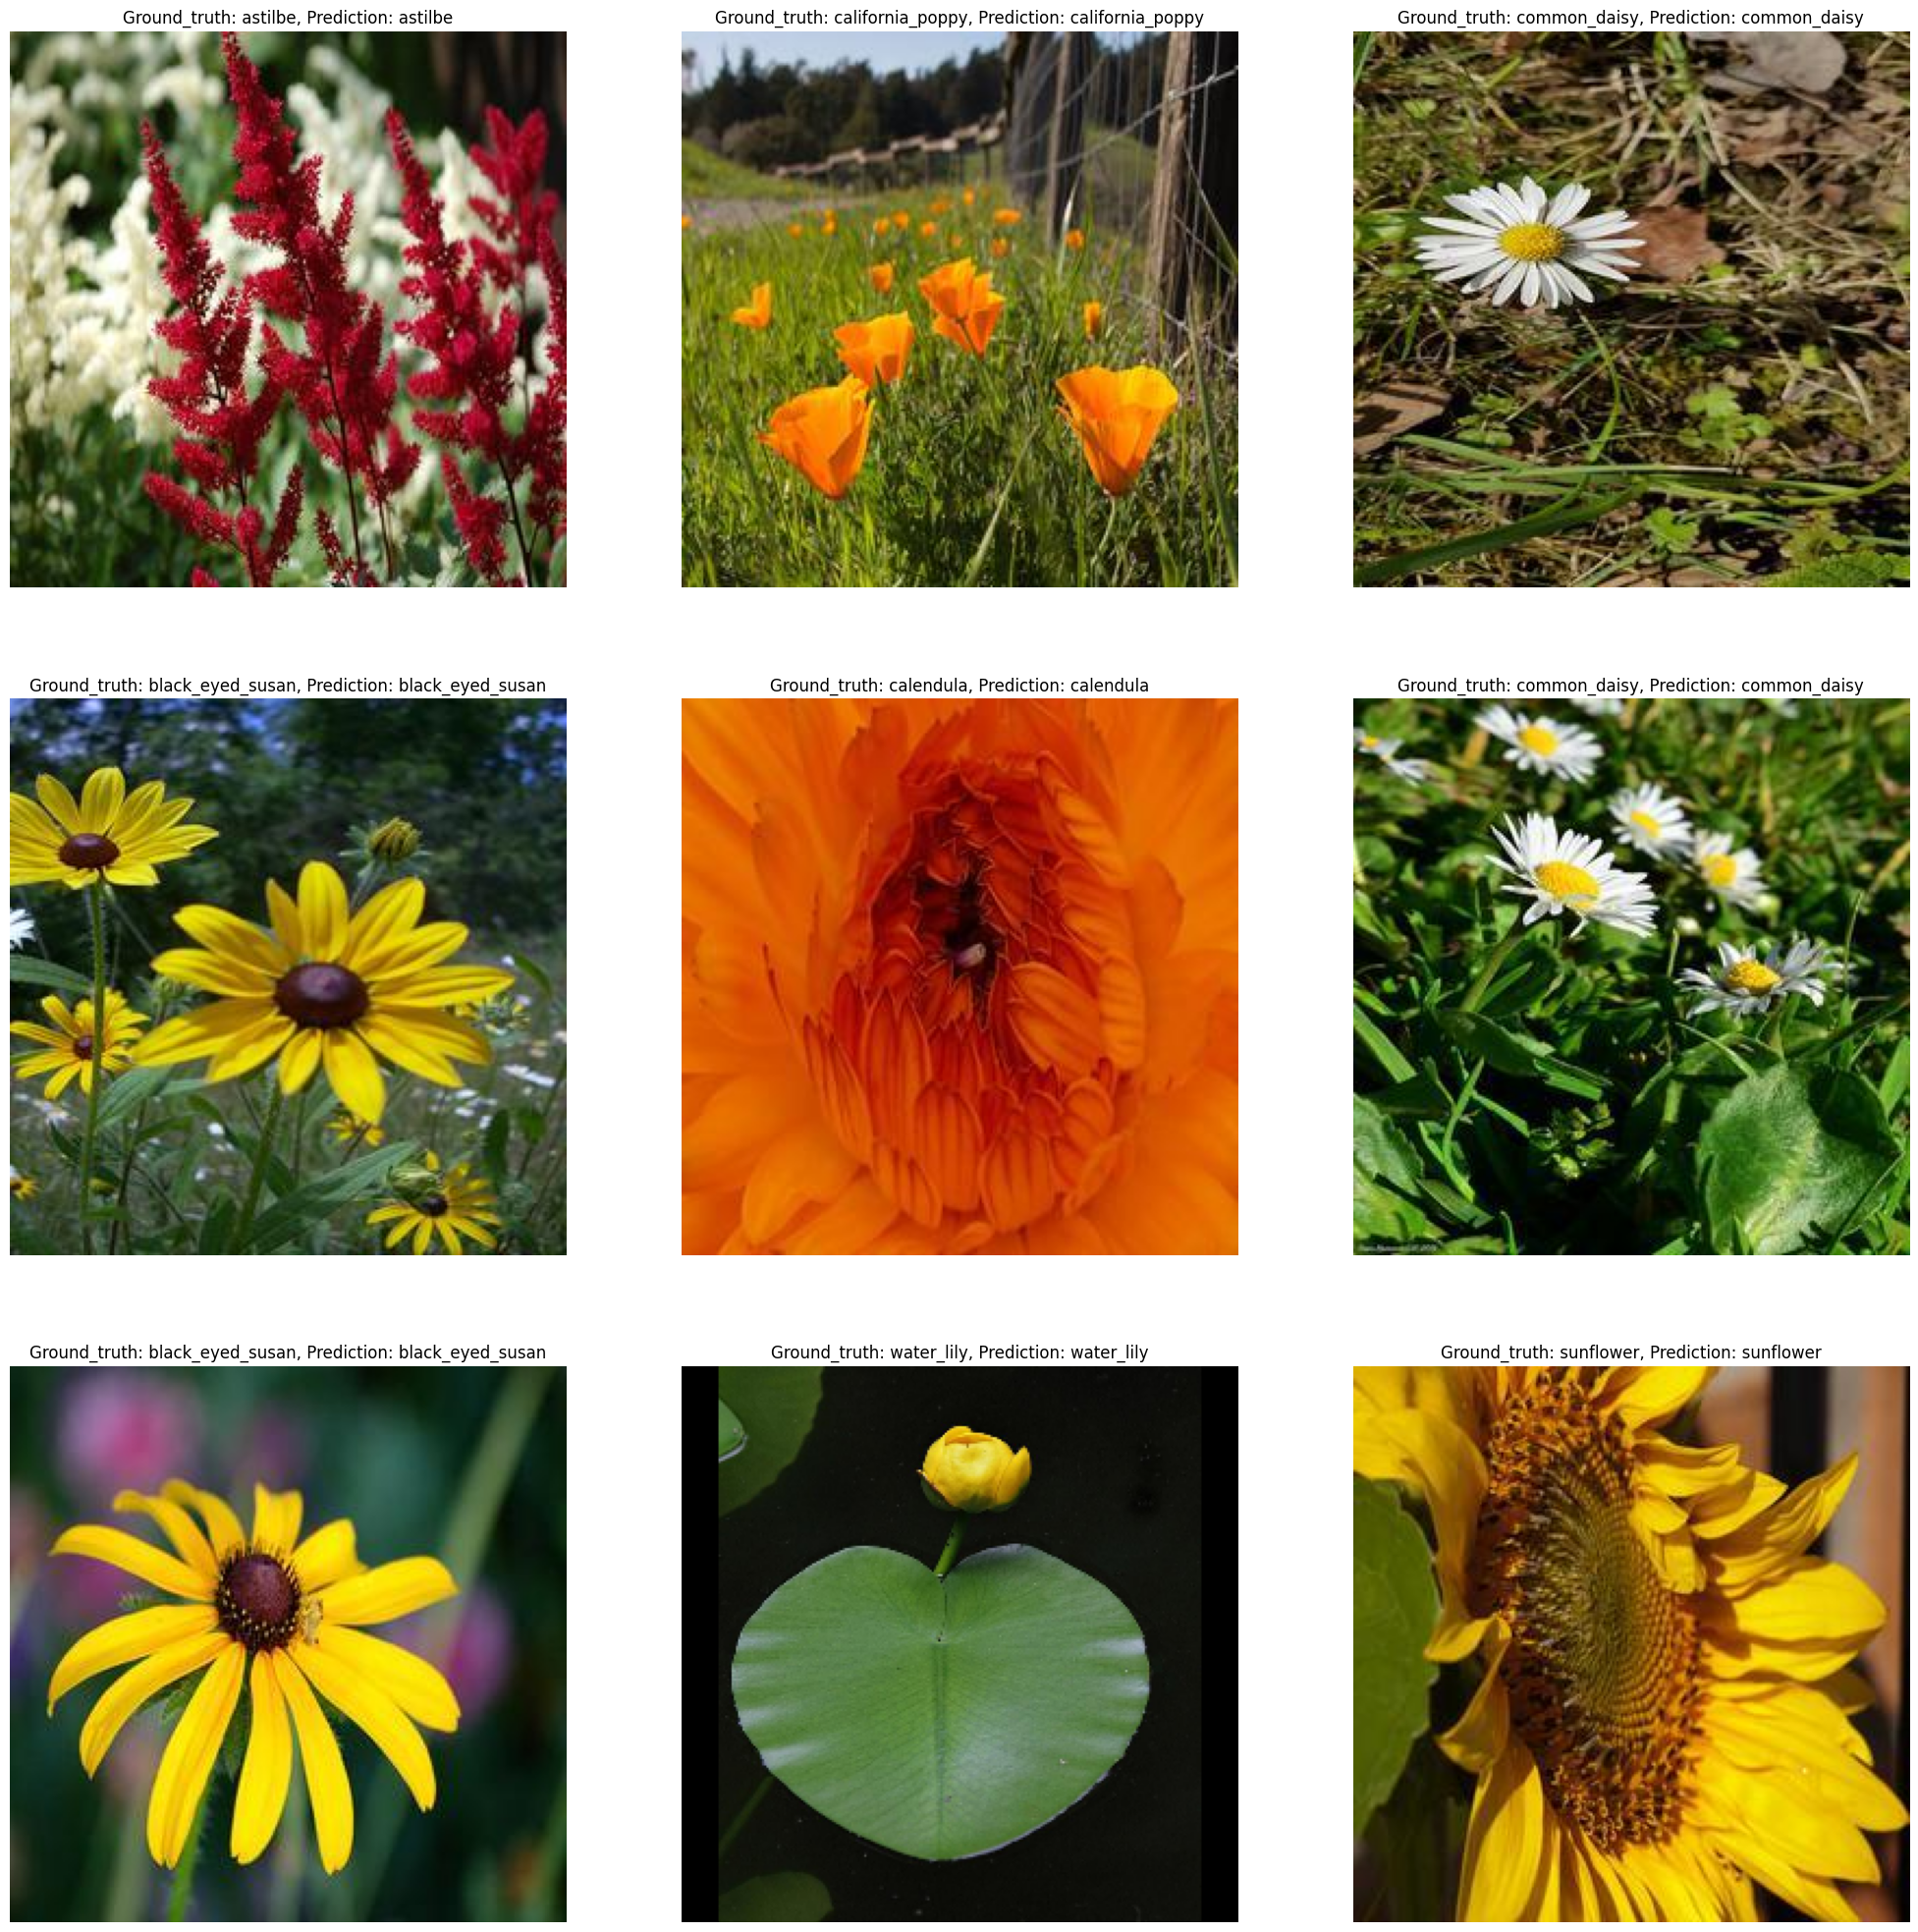

In [28]:
n_col = 3
n_plots = 3 * 3 // n_col
fig = plt.figure(figsize=(25, 25))


for n_image, (data, label) in enumerate(eval_dataset.take(3).as_numpy_iterator(), start=1):
    response = classify_flower(data, "localhost", "8501", "20231120-094457")
    for i in range(3):
        ax = fig.add_subplot(n_plots, n_col, (n_image - 1) * 3 + i + 1)
        print(response)
        ax.set_title(
            f"Ground_truth: {category_flower_mapping[extract_highest_scoring_category(label[i])]}"
            f", Prediction: {category_flower_mapping[extract_highest_scoring_category(label[i])]}"
        )
        ax.imshow(data[i].astype(int).squeeze())
        ax.axis("off")